The purpouse of this notebook is to show the data that we have.

In [44]:
import random

import torch
import matplotlib.pyplot as plt
from datasets import load_dataset
from torch.utils.data import DataLoader, Dataset

In [45]:
data = load_dataset("roszcz/ecg-segmentation-ltafdb")
test = data["test"]
validation = data["validation"]
train = data["train"]

print("Train size: ", len(train), "type: ", type(train))
print("Validation size: ", len(validation), "type: ", type(validation))
print("Test size: ", len(test), "type: ", type(test))


Found cached dataset parquet (C:/Users/samue/.cache/huggingface/datasets/roszcz___parquet/roszcz--ecg-segmentation-ltafdb-7923b6c5c377f948/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)


  0%|          | 0/3 [00:00<?, ?it/s]

Train size:  730278 type:  <class 'datasets.arrow_dataset.Dataset'>
Validation size:  83724 type:  <class 'datasets.arrow_dataset.Dataset'>
Test size:  89407 type:  <class 'datasets.arrow_dataset.Dataset'>


In [46]:
class CustomECGDataset(Dataset):
    def __init__(self, hf_dataset):
        self.hf_dataset = hf_dataset

    def __len__(self):
        return len(self.hf_dataset) * 4  # Each original sample will produce 4 new samples

    def __getitem__(self, index):
        original_index = index // 4  # Determine the index in the original dataset
        slice_index = index % 4  # Determine which slice (0, 1, 2, or 3)

        sample = self.hf_dataset[original_index]
        start = slice_index * 250
        end = start + 250

        channel1 = torch.tensor(sample["signal"][0][start:end])
        channel2 = torch.tensor(sample["signal"][1][start:end])

        return channel1, channel2

In [47]:
validation_dataset = CustomECGDataset(validation)
validation_dataloader = DataLoader(validation_dataset, batch_size=64, shuffle=True)

Validation dataset size:  334896
Validation dataloader size:  5233
Batch index:  0
Channel 1 shape:  torch.Size([64, 250])
Channel 2 shape:  torch.Size([64, 250])


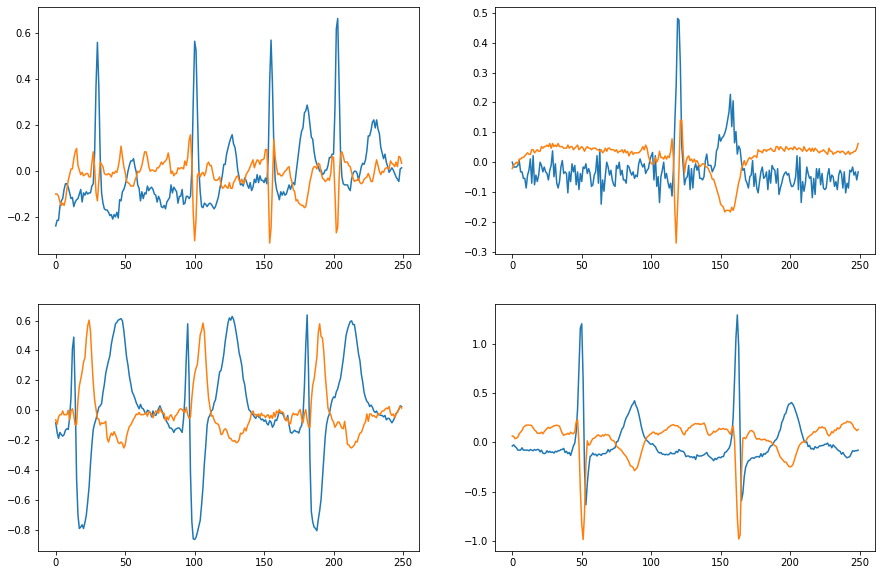

In [48]:
print("Validation dataset size: ", len(validation_dataset))
print("Validation dataloader size: ", len(validation_dataloader))

for i, (channel1, channel2) in enumerate(validation_dataloader):
    print("Batch index: ", i)
    print("Channel 1 shape: ", channel1.shape)
    print("Channel 2 shape: ", channel2.shape)

    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    for j in range(2):
        for i in range(2):
            axs[j, i].plot(channel1[j * 2 + i])
            axs[j, i].plot(channel2[j * 2 + i])
    plt.show()
    break


The chart above shows what we should expect from the signals generated by our generator.

Now for statistical analysis:

In [49]:
chanel1_stats = {
    "std": [],
    "mean": [],
    "max": [],
    "min": [],
}
chanel2_stats = {
    "std": [],
    "mean": [],
    "max": [],
    "min": [],
}

for i, (channel1, channel2) in enumerate(validation_dataloader):
    chanel1_stats["std"].append(channel1.std())
    chanel1_stats["mean"].append(channel1.mean())
    chanel1_stats["max"].append(channel1.max())
    chanel1_stats["min"].append(channel1.min())

    chanel2_stats["std"].append(channel2.std())
    chanel2_stats["mean"].append(channel2.mean())
    chanel2_stats["max"].append(channel2.max())
    chanel2_stats["min"].append(channel2.min())

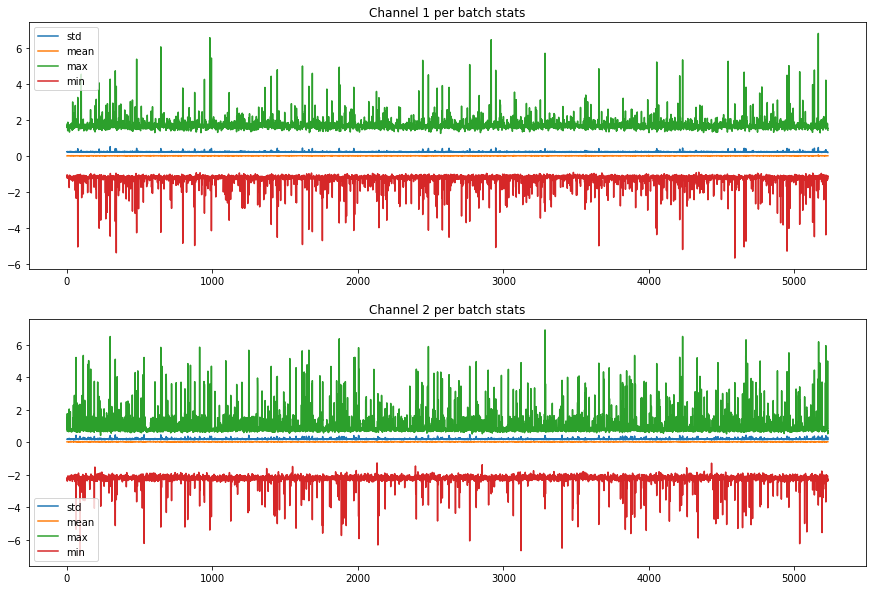

In [52]:
# Plot the statistics
fig, axs = plt.subplots(2, 1, figsize=(15, 10))
axs[0].plot(chanel1_stats["std"], label="std")
axs[0].plot(chanel1_stats["mean"], label="mean")
axs[0].plot(chanel1_stats["max"], label="max")
axs[0].plot(chanel1_stats["min"], label="min")
axs[0].legend()
axs[0].set_title("Channel 1 per batch stats")

axs[1].plot(chanel2_stats["std"], label="std")
axs[1].plot(chanel2_stats["mean"], label="mean")
axs[1].plot(chanel2_stats["max"], label="max")
axs[1].plot(chanel2_stats["min"], label="min")
axs[1].legend()
axs[1].set_title("Channel 2 per batch stats")

plt.show()